In [4]:
import xml
import xml.etree.ElementTree as ET
import os
from os import path
import glob
from collections import defaultdict, Counter, OrderedDict
import numpy as np

from utils import get_ent_info, get_clusters_from_xml
from plot_utils import initialize_bar_plot

import matplotlib.pyplot as plt
import numpy as np

# Change Matplotlib Parameters
plt.rc('text', usetex=True)  # Setting to use latex font; may require installing the TeX fonts
plt.rc('axes', labelcolor='b', edgecolor='k', 
       labelsize=18, titlesize=18)
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] =16
plt.rcParams['ytick.labelsize'] =16

In [5]:
root_dir = "/home/shtoshni/Research/events/data/red/"
source_dir = path.join(root_dir, "data/source")
source_files = glob.glob("{}/*/*".format(source_dir))

ann_dir = path.join(root_dir, "data/mod_annotation")
ann_files = glob.glob("{}/*/*".format(ann_dir))

split_types = ["train", "dev", "test"]

### Initialize BERT Tokenizer as well

In [6]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

### Stat function

In [7]:
def get_stats(source_files, annotation_files, split="train"):
    span_width = []
    clustered_span_width = []
    type_count = Counter()
    span_type_counter = Counter()
    cluster_sizes = defaultdict(list)
    singleton_count = Counter()
    num_clusters_per_doc = [] 
    for (source_file, annotation_file) in zip(source_files, annotation_files):
        # Read the source document
        doc_str = "".join(open(source_file).readlines())

        # Parse the XML
        tree = ET.parse(annotation_file)
        root = tree.getroot()

        # Get entity and cluster information from the annotation file
        ent_map, ent_list = get_ent_info(root)
        clusters = get_clusters_from_xml(root, ent_map)
        
        # Number of clusters in the doc
        num_clusters_per_doc.append(len(clusters))
        
        # Get cluster sizes
        cluster_elems = set()
        for cluster in clusters:
            first_ent = cluster[0]
            ent_type = ent_map[first_ent][0]
            cluster_sizes[ent_type].append(len(cluster)) 
            cluster_elems.update(cluster)
        
        # Get mention level stats - mention width etc
        span_to_type = {}
        for (span_start, span_end), elem_id in ent_list:
            elem_type = ent_map[elem_id][0]
            type_count[elem_type] += 1
            ent_str = doc_str[span_start: span_end]
            
            # Span widths
            cur_width = len(tokenizer.tokenize(ent_str))
            span_width.append(cur_width)
            if elem_id in cluster_elems:
                clustered_span_width.append(cur_width)
            
            span_ends = (span_start, span_end)
            if span_ends in span_to_type:
                # Next two assertions ensure that the two spans are different type and 
                # that there are no more than two elements for a span. 
                assert(span_to_type[span_ends] != elem_type)
                assert(span_to_type[span_ends] != 'BOTH')
                
                span_to_type[span_ends] = 'BOTH'
            else:
                span_to_type[span_ends] = elem_type
                
        
        for span_type in span_to_type.values():
            span_type_counter[span_type] += 1
    
        
        for elem_id in ent_map:
            elem_type = ent_map[elem_id][0]
            if elem_id not in cluster_elems:
                singleton_count[elem_type] += 1
        
            
    def bar_plot(labels, counts, xlim=None, title=None):
        fig, ax = initialize_bar_plot()

        bar_width=0.3
        cur_bar = ax.bar(bar_width + np.arange(len(labels)), counts,
                      color=['teal', 'r'], width=bar_width, alpha=0.6)
        plt.xticks(np.arange(len(labels)) + bar_width, labels, rotation=0) 

        for rect, height, label in zip(cur_bar, counts, labels):
            label = f'{height}'
            ax.text(rect.get_x() + rect.get_width()/2, height + 0.25, label, ha='center', va='bottom')
        
        if xlim is not None:
            plt.xlim(*xlim)
            
        if title is not None:
            plt.title(title)
        plt.show()
        
    
    # Span width
    plt.hist(span_width)
    plt.title(f"Histogram of span width for {split.capitalize()}")
    plt.show()
    print(f"Max span width: {np.max(span_width)}")
    
    # Non-singleton span widths
    plt.hist(clustered_span_width)
    plt.title(f"Histogram of clustered span widths for {split.capitalize()}")
    plt.show()
    print(f"Max clustered span width: {np.max(clustered_span_width)}")
    
    # Type counts
    labels, counts = zip(*type_count.items())
    bar_plot(labels, counts, xlim=[-0.2, 1.8])
    
    # Span type
    labels, counts = zip(*span_type_counter.items())
    bar_plot(labels, counts)
    
    # Number of clusters
    plt.hist(num_clusters_per_doc)
    plt.title(f"Histogram of number of clusters for {split.capitalize()}")
    plt.show()
    print(f"Max clusters: {np.max(num_clusters_per_doc)}")
    
    # Singleton count
    labels, counts = zip(*singleton_count.items())
    bar_plot(labels, counts, title='Singleton Count')

    for cluster_type, cluster_lens in cluster_sizes.items():
        plt.hist(cluster_lens)
        plt.title(f"Histogram of cluster sizes for {cluster_type}")
        print(f"Max cluster size: {np.max(cluster_lens)}")
        plt.show()
        
        

### Next load list of files in each split 

In [8]:
def prefix_to_data_files(split_files):
    source_files, annotation_files = [], []
    for split_file in split_files:
        source_files.append(path.join(source_dir, split_file))
        annotation_files.append(path.join(ann_dir, split_file) + ".RED-Relation.gold.completed.xml")
        
    return source_files, annotation_files

In [9]:
split_info_dir = path.join(root_dir, "docs")

split_to_file_list = OrderedDict()
for split in split_types:
    split_list_file = path.join(split_info_dir, f'{split}.txt')
    split_files = set([file_name.strip() for file_name in open(split_list_file).readlines()])
    split_to_file_list[split] = split_files

### Train Stats

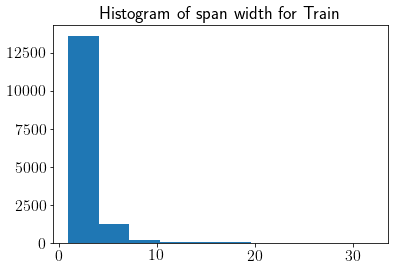

Max span width: 32


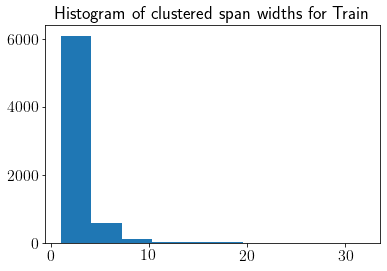

Max clustered span width: 32


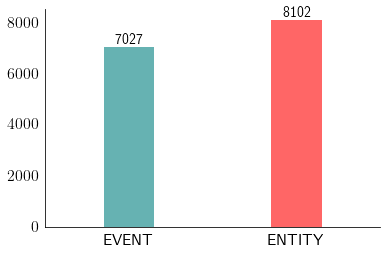

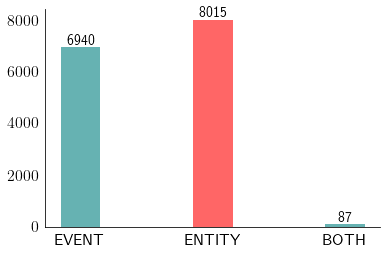

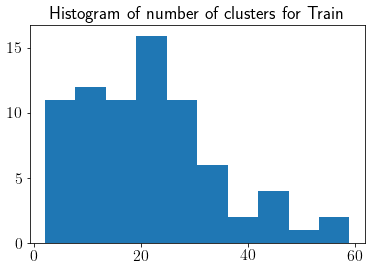

Max clusters: 59


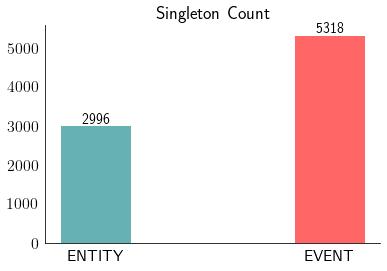

Max cluster size: 71


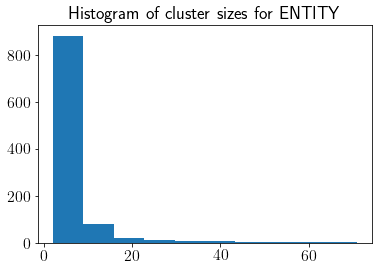

Max cluster size: 21


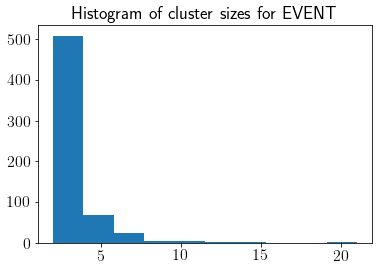

In [10]:
source_files, annotation_files = prefix_to_data_files(split_to_file_list["train"])
get_stats(source_files, annotation_files, split="train")

### Dev stats

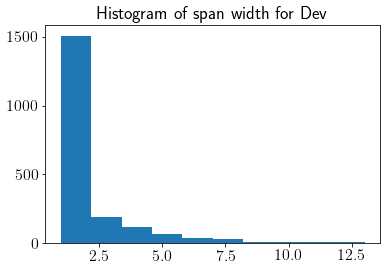

Max span width: 13


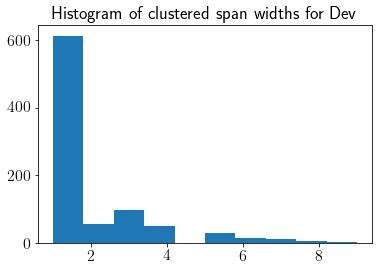

Max clustered span width: 9


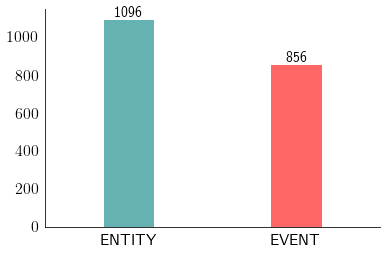

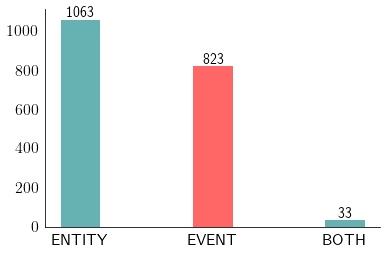

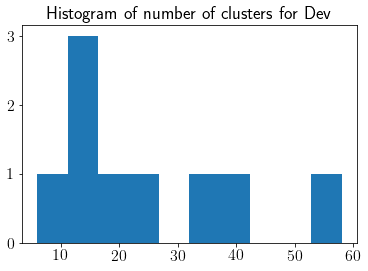

Max clusters: 58


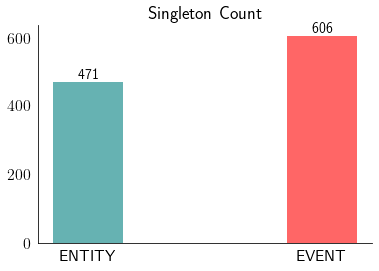

Max cluster size: 45


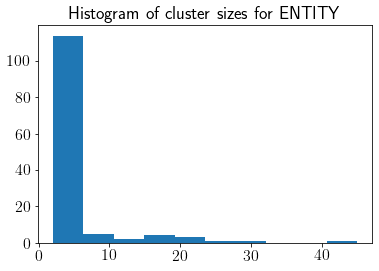

Max cluster size: 18


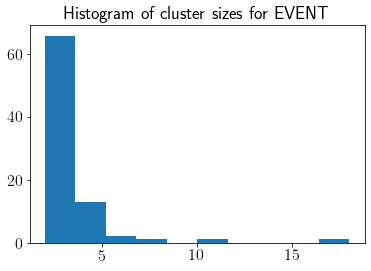

In [11]:
source_files, annotation_files = prefix_to_data_files(split_to_file_list["dev"])
get_stats(source_files, annotation_files, split="dev")

### Removing the NYT doc

['/home/shtoshni/Research/events/data/red/data/source/deft/NYT_ENG_20131029.0091', '/home/shtoshni/Research/events/data/red/data/source/proxy/PROXY_AFP_ENG_20020128_0449', '/home/shtoshni/Research/events/data/red/data/source/pilot/57026b7bcb8f855de3e26d572db35285', '/home/shtoshni/Research/events/data/red/data/source/pilot/soc.culture.china_20050203.0639', '/home/shtoshni/Research/events/data/red/data/source/deft/17a2dc40635ec239e9e16d10b6dd45e8.mpdf', '/home/shtoshni/Research/events/data/red/data/source/proxy/PROXY_AFP_ENG_20020406_0538', '/home/shtoshni/Research/events/data/red/data/source/deft/NYT_ENG_20130613.0153', '/home/shtoshni/Research/events/data/red/data/source/deft/96bf72399b104346f3e79022e0c08e5a.mpdf']


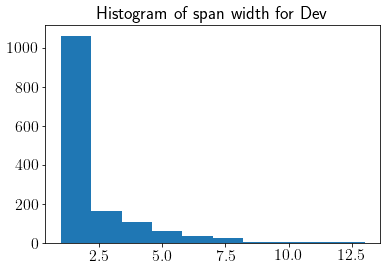

Max span width: 13


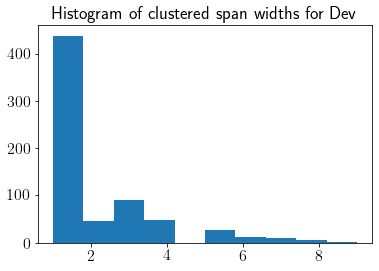

Max clustered span width: 9


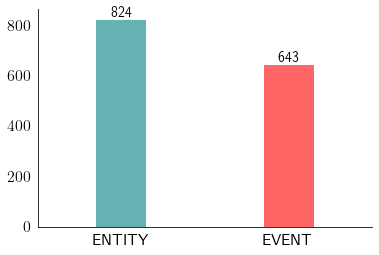

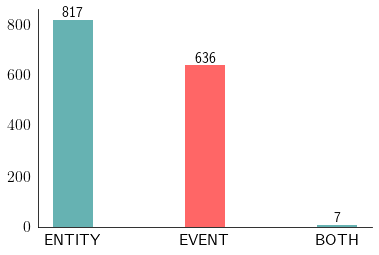

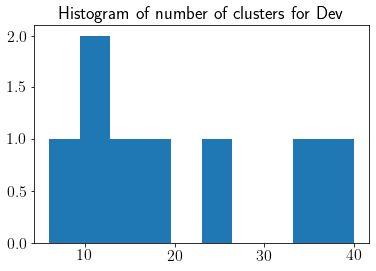

Max clusters: 40


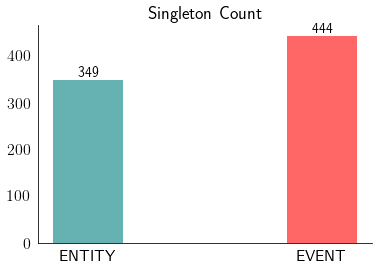

Max cluster size: 45


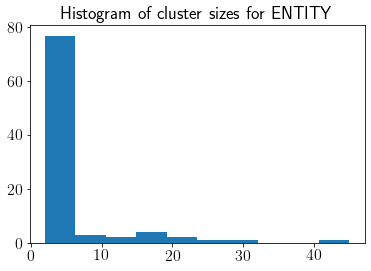

Max cluster size: 18


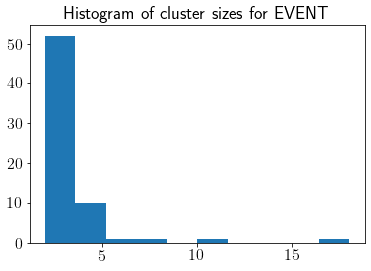

In [12]:
source_files, annotation_files = prefix_to_data_files(split_to_file_list["dev"])
source_files = [source_file for source_file in source_files if "0047" not in source_file]
annotation_files = [source_file for source_file in annotation_files if "0047" not in source_file]
# print(source_files)
get_stats(source_files, annotation_files, split="dev")

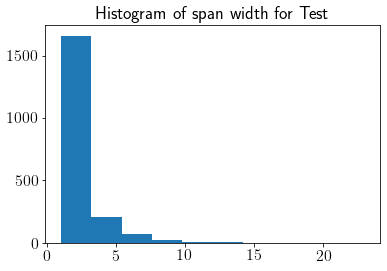

Max span width: 23


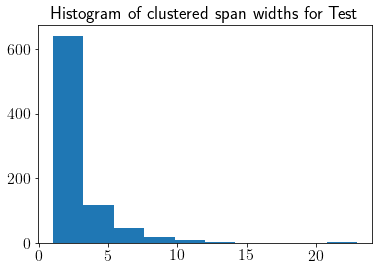

Max clustered span width: 23


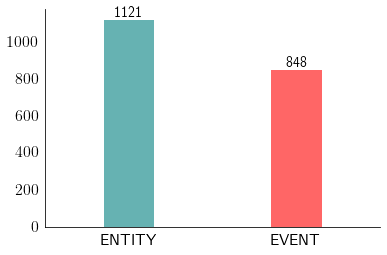

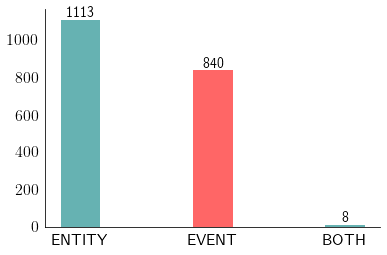

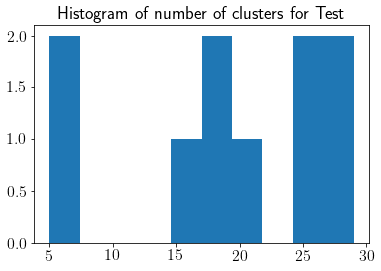

Max clusters: 29


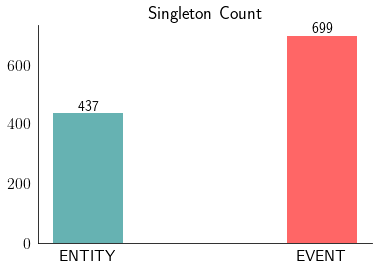

Max cluster size: 82


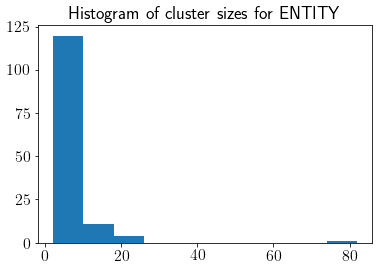

Max cluster size: 11


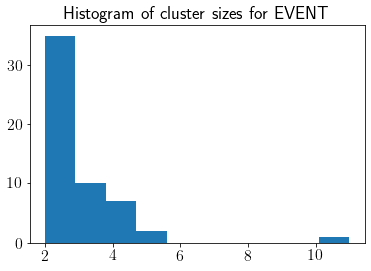

In [13]:
source_files, annotation_files = prefix_to_data_files(split_to_file_list["test"])
get_stats(source_files, annotation_files, split="test")